# CrowdTruth metrics 2.0 documentation

Let:

* $workers(u):$ all workers that annotate media unit $u$;
* $units(i):$ all input media units annotated by worker $i$;
* $WorkVec(i, u):$ annotations of worker $i$ on media unit $u$ as a binary vector;
* $MediaUnitVec(s) = \sum_{i \in workers(s)} WorkVec(i,s)$, where $s$ is an input media unit.

## Media Unit Quality Score (UQS)

The unit quality score $UQS(u)$ is computed as the average cosine similarity between all worker vectors for a given input media unit $u$, weighted by the worker quality ($WQS$) and annotation quality ($AQS$). The goal is to capture the degree of agreement in annotating the media unit. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score.

$$ UQS(u) = \frac{\sum_{i, j \in workers(u)} Wcos(WorkVec(i,u), WorkVec(j,u)) \; WQS(i) \; WQS(j)}{\sum_{i, j \in workers(u)} WQS(i) \; WQS(j)}, \; i \neq j.$$


### Weighted Cosine

To weigh the metrics with the annotation quality, we compute $Wcos$, the weighted version of the cosine similarity. This metric is only applicable to closed tasks, where annotation quality can be calculated across media units. For open-ended tasks, we consider annotation quality equal to 1 and calculate the regular cosine similarity.

$$ Wcos(vec_1, vec_2) = \frac{\sum_{a} vec_1(a) \; vec_2(a) \; AQS(a)}{\sqrt{(\sum_{a} vec_1^2(a) \; AQS(a)) \; (\sum_{a} vec_2^2(a) \; AQS(a))}} .$$ 


## Worker Quality Score (WQS)

The worker quality score $WQS(i)$ for a given worker $i$ is the product of 2 separate metrics - the worker-worker agreement $WWA(i)$ and the worker-media unit agreement $WUA(i)$.

$$ WQS(i) = WUA(i) \; WWA(i) .$$

### Worker-Media Unit Agreement

The worker-media unit agreement $WUA(i)$ is the average cosine distance between the annotations of a worker $i$ and all annotations for the media units they have worked on, weighted by the media unit and annotation quality. It calculates how much a worker disagrees with the crowd on a media unit basis. Through the weighted average, media units and anntation with lower quality will have less of an impact on the final score.

$$ WSA(i) = \frac{\sum_{u \in units(i)} Wcos(WorkVec(i,u), MediaUnitVec(u) - WorkVec(i, u)) \; UQS(u)}{\sum_{u \in units(i)} UQS(u)} .$$

### Worker-Worker Agreement

The worker-worker agreement $WWA(i)$ is the average cosine distance between the annotations of a worker $i$ and all other workers that have worked on the same media units as worker $i$, weighted by the worker and annotation qualities. The metric gives an indication as to whether there are consisently like-minded workers. This is useful for identifying communities of thought. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score of the given worker.

$$ WWA(i) = \frac{ \sum_{j \in workers(u \in units(i))} Wcos(WorkVec(i, u), WorkVec(j, u)) \; WQS(j) \; UQS(u) }{ \sum_{j \in workers(s \in units(i))} WQS(j) \; UQS(u) }, \; i \neq j .$$


## Annotation Quality Score (AQS)

The annotation quality score $AQS(a)$ calculates the agreement of selecting an annotation $a$, over all the media units it appears in. Therefore, it is only applicable to closed tasks, where the same annotation set is used for all input media units. It is based on $P_a(i | j)$, the probability that if a worker $j$ annotates $a$ in a media unit, worker $i$ will also annotate it. 

$$ P_a(i | j) = \frac{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(i, s)(r) \; WorkVec(j, s)(r) }{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(j, u)(r) } . $$

$AQS(a)$ is the weighted average of $P_a(i | j)$ for all possible pairs of workers. Through the weighted average, input media units and workers with lower quality will have less of an impact on the final score of the annotation.

$$ AQS(a) = \frac{ \sum_{i,j} WQS(i) \; WQS(j) \; P_a(i | j) }{ \sum_{i,j} WQS(i) \; WQS(j) }, i \neq j . $$


## Media Unit-Annotation Score (UAS)

The media unit - annotation score $UAS(u, a)$ calculates the likelihood that annotation $a$ is expressed in input media unit $u$. It is the ratio of the number of workers that picked annotation $u$ over all workers that annotated the unit, weighted by the worker quality.

$$ UAS(u, a) = \frac{ \sum_{i \in workers(u)} WorkVec(i,u)(a) \; WQS(i) }{ \sum_{i \in workers(u)} WQS(i) }. $$

# How to run the metrics

In [1]:
# Read data

import pandas as pd

pd.set_option('display.max_columns', None)
event_validation_filename = "event_extraction_all.csv"
event_validation_dataset = pd.read_csv(event_validation_filename)

event_validation_dataset.head(10)

,_unit_id,_created_at,_id,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,_city,_ip,hiddeninput,selectedtags_desc,_pos_tags_vb,doc_id,event_lemma,event_tokens,events,hiddeninput_gold,index,selectedtags_desc_gold,sentence,sentence_id,stanford_lemmas,stanford_pos_tags,tokens,validate_verbs
0,1368377112,9/6/2017 21:54:18,2811523824,9/6/2017 21:53:13,False,prodege,1,11131207,CAN,ON,Scarborough,99.232.31.152,NaN,"[""called_84_90""]",2,VOA19980305.1800.2603,4,4,0,NaN,497,NaN,"An Afghan refugee in Switzerland , Homira Atim...",6,"a Afghan refugee in Switzerland , Homira Atima...","DT NNP NN IN NNP , NNP NNP , VBZ DT JJ NN IN D...",25,in_18_20 is_52_54 called_84_90 on_123_125
1,1368377112,9/6/2017 21:54:28,2811524123,9/6/2017 21:54:11,False,elite,1,43836412,USA,FL,Miami,23.27.45.253,NaN,"[""in_18_20"",""is_52_54"",""called_84_90"",""on_123_...",2,VOA19980305.1800.2603,4,4,0,NaN,497,NaN,"An Afghan refugee in Switzerland , Homira Atim...",6,"a Afghan refugee in Switzerland , Homira Atima...","DT NNP NN IN NNP , NNP NNP , VBZ DT JJ NN IN D...",25,in_18_20 is_52_54 called_84_90 on_123_125
2,1368377112,9/6/2017 21:57:51,2811529440,9/6/2017 21:57:03,False,elite,1,43818472,USA,NJ,Edison,196.53.35.244,NaN,"[""in_18_20"",""is_52_54"",""called_84_90"",""on_123_...",2,VOA19980305.1800.2603,4,4,0,NaN,497,NaN,"An Afghan refugee in Switzerland , Homira Atim...",6,"a Afghan refugee in Switzerland , Homira Atima...","DT NNP NN IN NNP , NNP NNP , VBZ DT JJ NN IN D...",25,in_18_20 is_52_54 called_84_90 on_123_125
3,1368377112,9/6/2017 21:58:59,2811531187,9/6/2017 21:58:46,False,elite,1,43745902,USA,FL,Miami,23.27.45.253,NaN,"[""in_18_20"",""is_52_54"",""called_84_90"",""on_123_...",2,VOA19980305.1800.2603,4,4,0,NaN,497,NaN,"An Afghan refugee in Switzerland , Homira Atim...",6,"a Afghan refugee in Switzerland , Homira Atima...","DT NNP NN IN NNP , NNP NNP , VBZ DT JJ NN IN D...",25,in_18_20 is_52_54 called_84_90 on_123_125
4,1368377112,9/6/2017 22:02:17,2811536353,9/6/2017 22:02:02,False,elite,1,43783971,USA,CA,San Jose,68.68.96.46,NaN,"[""in_18_20"",""is_52_54"",""called_84_90"",""on_123_...",2,VOA19980305.1800.2603,4,4,0,NaN,497,NaN,"An Afghan refugee in Switzerland , Homira Atim...",6,"a Afghan refugee in Switzerland , Homira Atima...","DT NNP NN IN NNP , NNP NNP , VBZ DT JJ NN IN D...",25,in_18_20 is_52_54 called_84_90 on_123_125
5,1368377112,9/6/2017 22:03:17,2811538064,9/6/2017 22:03:12,False,clixsense,1,6576528,CAN,SK,Regina,24.72.133.122,NaN,"[""called_84_90""]",2,VOA19980305.1800.2603,4,4,0,NaN,497,NaN,"An Afghan refugee in Switzerland , Homira Atim...",6,"a Afghan refugee in Switzerland , Homira Atima...","DT NNP NN IN NNP , NNP NNP , VBZ DT JJ NN IN D...",25,in_18_20 is_52_54 called_84_90 on_123_125
6,1368377112,9/6/2017 22:04:03,2811539278,9/6/2017 22:03:21,False,elite,1,43792193,USA,FL,Miami,23.27.45.253,NaN,"[""in_18_20"",""is_52_54"",""called_84_90"",""on_123_...",2,VOA19980305.1800.2603,4,4,0,NaN,497,NaN,"An Afghan refugee in Switzerland , Homira Atim...",6,"a Afghan refugee in Switzerland , Homira Atima...","DT NNP NN IN NNP , NNP NNP , VBZ DT JJ NN IN D...",25,in_18_20 is_52_54 called_84_90 on_123_125
7,1368377112,9/6/2017 22:04:51,2811540747,9/6/2017 22:04:38,False,neodev,1,43840516,USA,PA,Bethlehem,71.126.114.235,NaN,"[""in_18_20"",""is_52_54"",""called_84_90"",""on_123_...",2,VOA19980305.1800.2603,4,4,0,NaN,497,NaN,"An Afghan refugee in Switzerland , Homira Atim...",6,"a Afghan refugee in Switzerland , Homira Atima...","DT NNP NN IN NNP , NNP NNP , VBZ DT JJ NN IN D...",25,in_18_20 is_52_54 called_84_90 on_123_125
8,1368377112,9/6/2017 22:06:41,2811543912,9/6/2017 22:05:28,False,coinworker,1,41920197,USA,NY,Buffalo,192.3.224.227,NaN,"[""called_84_90""]",2,VOA19980305.1800.2603,4,4,0,NaN,497,NaN,"An Afghan refugee in Switzerland , Homira Atim...",6,"a Afghan refugee in Switzerland , Homira Atima...","DT NNP NN IN NNP , NNP NNP , VBZ DT JJ NN IN D...",25,in_18_20 is_52_54 called_84_90 on_123_125
9,1368377112,9/6/2017 

### Total amount of units that were crowdsourced


In [2]:
len(event_validation_dataset["_unit_id"].unique())

626

### Creating a class that inherits from `Configuration` lets us define how the input file will be processed:

* `inputColumns`: list of input columns from the .csv file, the input that the workers were shown
* `outputColumns`: list of output columns with the answers from the workers
* `processJudgments`: function that defines how the worker judgments wil be processed; default separator for judgments is ','

To build the annotation vector, we also need to specify whether this is an **open-ended** or **closed** task, using the `open_ended_task` variable.

* **open-ended task** means that the annotation space is not known, and workers can freely provide all the choices that apply (e.g. in sound tagging, the workers are provided with a text box to enter all tags they can think of)
* **closed task** means that the annotations that can occur in the data are already known, and the workers are asked to validate their existence (e.g. for medical relation extraction, the workers pick from a pre-defined multiple-choice set of relations)

If the task we are processing is **closed**, then we also need to provide the list of possible annotations in the `annotation_vector` variable.

In [3]:
import sys
sys.path.append('../')

from defaultconfig import Configuration

class EventValidationConfig(Configuration):
    inputColumns = ["doc_id", "index", "sentence_id", "sentence", "validate_verbs"]
    outputColumns = ["selectedtags_desc"]
    
    # processing of a closed task
    open_ended_task = True
    annotation_vector = [
        "causes", "manifestation", "treats", "prevents", "symptom", "diagnose_by_test_or_drug", "location",
        "side_effect", "contraindicates", "associated_with", "is_a", "part_of", "other", "none"
    ]
    
    def processJudgments(self, judgments):
        # change default separator to whitespace to make it work with our file
        for col in self.outputColumns:
            judgments[col] = judgments[col].apply(lambda x: x.replace(' ',','))
        return judgments

config = EventValidationConfig()

### Pre-process the data and create the annotation vectors

In [4]:

from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=event_validation_filename,
    config=config
)

### Run the metrics

In [5]:
# run the metrics
from models import Metrics
processed_results = Metrics.run(pre_processed_results, config)

#### Print the results for the units in our dataset

In [6]:
processed_results["units"]

,duration,input.doc_id,input.index,input.sentence,input.sentence_id,input.validate_verbs,job,metrics.avg_annotations,metrics.avg_cos_clarity,metrics.avg_unique_annotations,output.selectedtags_desc,output.selectedtags_desc.annotations,output.selectedtags_desc.cos_clarity,output.selectedtags_desc.unique_annotations,worker,uqs,uqs_initial,unit_annotation_score,unit_annotation_score_initial
unit,,,,,,,,,,,,,,,,,,,
1366706096,60.133333,wsj_0938,241,`` Where 's the bid ? '' asked Pierre Panet-Ra...,22,s_9_11 asked_25_30,event_extraction_all,18.0,0.980581,2.0,"{u'asked_25_30': 15, u's_9_11': 3}",18,0.980581,2,15,0.898308,0.899579,"{u'asked_25_30': 1.0, u's_9_11': 0.201559727528}","{u'asked_25_30': 1.0, u's_9_11': 0.2}"
1366706097,37.133333,wsj_1013,242,Its ratio of tangible equity to total assets a...,24,was_60_63 was_89_92,event_extraction_all,22.0,0.758098,3.0,"{u'no_event': 5, u'was_89_92': 10, u'was_60_63...",22,0.758098,3,15,0.503735,0.465231,"{u'no_event': 0.267278361585, u'was_89_92': 0....","{u'no_event': 0.333333333333, u'was_89_92': 0...."
1366706098,35.133333,wsj_0612,243,The debentures are convertible into common sto...,1,are_15_18 representing_67_79,event_extraction_all,21.0,0.800132,3.0,"{u'no_event': 2, u'representing_67_79': 11, u'...",21,0.800132,3,15,0.655668,0.539986,"{u'no_event': 0.0695080405712, u'representing_...","{u'no_event': 0.133333333333, u'representing_6..."
1366706099,32.933333,wsj_0152,244,"Dow Jones publishes The Wall Street Journal , ...",7,publishes_10_19 operates_96_104,event_extraction_all,30.0,0.707107,2.0,"{u'operates_96_104': 15, u'publishes_10_19': 15}",30,0.707107,2,15,1.000000,1.000000,"{u'operates_96_104': 1.0, u'publishes_10_19': ...","{u'operates_96_104': 1.0, u'publishes_10_19': ..."
1366706100,29.800000,wsj_1006,245,The three units are a nationwide pharmaceutica...,11,are_16_19,event_extraction_all,15.0,0.894427,2.0,"{u'are_16_19': 5, u'no_event': 10}",15,0.894427,2,15,0.481248,0.523810,"{u'are_16_19': 0.400410328499, u'no_event': 0....","{u'are_16_19': 0.333333333333, u'no_event': 0...."
1366706101,56.200000,wsj_0585,246,The OTC stocks in the SampP 500 include Nasdaq...,31,include_32_39,event_extraction_all,15.0,0.894427,2.0,"{u'no_event': 5, u'include_32_39': 10}",15,0.894427,2,15,0.624289,0.523810,"{u'no_event': 0.2243565243, u'include_32_39': ...","{u'no_event': 0.333333333333, u'include_32_39'..."
1366706102,25.000000,wsj_0745,247,"In the end , Sir John -- rather than the gover...",28,hold_82_86 unlocks_100_107,event_extraction_all,25.0,0.705882,3.0,"{u'no_event': 1, u'hold_82_86': 12, u'unlocks_...",25,0.705882,3,15,0.782184,0.716993,"{u'no_event': 0.0370921897808, u'hold_82_86': ...","{u'no_event': 0.0666666666667, u'hold_82_86': ..."
1366706103,37.133333,wsj_1013,248,The results include a $ 130.2 million write-do...,7,include_12_19,event_extraction_all,15.0,0.939793,2.0,"{u'no_event': 4, u'include_12_19': 11}",15,0.939793,2,15,0.663557,0.580952,"{u'no_event': 0.193047190493, u'include_12_19'...","{u'no_event': 0.266666666667, u'include_12_19'..."
1366706104,29.866667,wsj_0768,249,Mutual funds are the among the largest holders...,15,are_13_16 accounting_57_67,event_extraction_all,19.0,0.889297,3.0,"{u'accounting_57_67': 11, u'are_13_16': 4, u'n...",19,0.889297,3,15,0.552373,0.502848,"{u'accounting_57_67': 0.797705160768, u'are_13...","{u'accounting_57_67': 0.733333333333, u'are_13..."


### Plot the unit quality score (UQS) at the beginning of the process and at the end

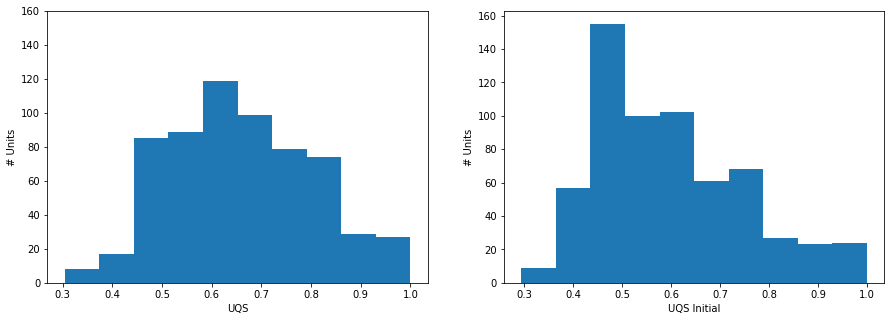

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(processed_results["units"]["uqs"])
plt.ylim(0, 160)
plt.xlabel("UQS")
plt.ylabel("# Units")

plt.subplot(1, 2, 2)
plt.hist(processed_results["units"]["uqs_initial"])
plt.xlabel("UQS Initial")
plt.ylabel("# Units")

### Plot the change in unit qualtity score at the beginning of the process and at the end

In [8]:
sortUQS = processed_results["units"].sort(['uqs'], ascending=[1])

In [9]:
sortUQS

,duration,input.doc_id,input.index,input.sentence,input.sentence_id,input.validate_verbs,job,metrics.avg_annotations,metrics.avg_cos_clarity,metrics.avg_unique_annotations,output.selectedtags_desc,output.selectedtags_desc.annotations,output.selectedtags_desc.cos_clarity,output.selectedtags_desc.unique_annotations,worker,uqs,uqs_initial,unit_annotation_score,unit_annotation_score_initial
unit,,,,,,,,,,,,,,,,,,,
1368376212,29.133333,wsj_0760,619,"Operating profit for the abrasives , engineeri...",2,Operating_0_9 profit_10_16 for_17_20 services_...,event_extraction_all,27.0,0.698963,7.0,"{u'no_event': 5, u'operating_0_9': 8, u'for_17...",27,0.698963,7,15,0.303981,0.309057,"{u'no_event': 0.289607181707, u'operating_0_9'...","{u'no_event': 0.333333333333, u'operating_0_9'..."
1368376963,27.533333,NYT19980206.0460,438,Among people with less than a high school educ...,37,Among_0_5 high_30_34 in_63_65 was_74_77,event_extraction_all,22.0,0.724286,5.0,"{u'no_event': 8, u'among_0_5': 4, u'high_30_34...",22,0.724286,5,15,0.315055,0.366416,"{u'no_event': 0.419657913662, u'among_0_5': 0....","{u'no_event': 0.533333333333, u'among_0_5': 0...."
1368376951,42.266667,PRI19980303.2000.2550,426,The instruction is in English for most classes...,6,is_16_18 in_19_21 for_30_33 in_49_51 for_59_62,event_extraction_all,30.0,0.620920,6.0,"{u'no_event': 4, u'in_49_51': 4, u'in_19_21': ...",30,0.620920,6,15,0.333413,0.293359,"{u'no_event': 0.253628035645, u'in_49_51': 0.3...","{u'no_event': 0.266666666667, u'in_49_51': 0.2..."
1366706764,40.200000,wsj_0610,233,The new facility was to have been the world 's...,30,was_17_20 have_24_28 been_29_33,event_extraction_all,22.0,0.538816,4.0,"{u'no_event': 6, u'been_29_33': 6, u'was_17_20...",22,0.538816,4,15,0.341448,0.323221,"{u'no_event': 0.341401569609, u'been_29_33': 0...","{u'no_event': 0.4, u'been_29_33': 0.4, u'was_1..."
1368377148,25.733333,wsj_0557,533,Baby Ruth and Butterfinger are both among the ...,13,are_27_30 among_36_41 in_76_78 market_144_150 ...,event_extraction_all,33.0,0.511891,6.0,"{u'is_151_153': 6, u'market_144_150': 5, u'no_...",33,0.511891,6,15,0.354872,0.322156,"{u'is_151_153': 0.509556152723, u'market_144_1...","{u'is_151_153': 0.4, u'market_144_150': 0.3333..."
1366706756,19.933333,wsj_0781,225,But while the chip 's speed in processing powe...,41,is_48_50 s_65_67 lies_82_86,event_extraction_all,20.0,0.749269,4.0,"{u'no_event': 4, u'is_48_50': 5, u's_65_67': 3...",20,0.749269,4,15,0.358015,0.322099,"{u'no_event': 0.235580070559, u'is_48_50': 0.4...","{u'no_event': 0.266666666667, u'is_48_50': 0.3..."
1368377153,29.200000,wsj_0760,538,"Operating profit for the abrasives , engineeri...",2,Operating_0_9 profit_10_16 for_17_20 was_90_93,event_extraction_all,25.0,0.683486,5.0,"{u'no_event': 4, u'operating_0_9': 8, u'for_17...",25,0.683486,5,15,0.361608,0.296732,"{u'no_event': 0.240188516753, u'operating_0_9'...","{u'no_event': 0.266666666667, u'operating_0_9'..."
1368377074,51.000000,wsj_0768,496,Mutual funds are the among the largest holders...,15,are_13_16 among_21_26 accounting_57_67 for_68_...,event_extraction_all,27.0,0.704934,6.0,"{u'among_21_26': 2, u'are_13_16': 7, u'for_68_...",27,0.704934,6,15,0.362160,0.341306,"{u'among_21_26': 0.176050580476, u'accounting_...","{u'among_21_26': 0.133333333333, u'accounting_..."
1366706105,38.333333,VOA19980305.1800.2603,250,"An Afghan refugee in Switzerland , Homira Atim...",6,is_52_54 called_84_90,event_extraction_all,17.0,0.780720,3.0,"{u'no_event': 5, u'called_84_90': 8, u'is_52_5...",17,0.780720,3,15,0.381391,0.364892,"{u'no_event': 0.28232271379, u'called_84_90': ...","{u'no_event': 0.333333333333, u'called_84_90':..."


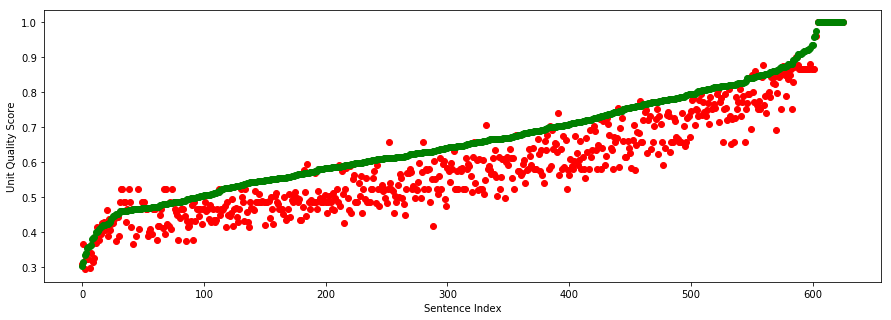

In [10]:
import numpy as np

plt.rcParams['figure.figsize'] = 15, 5

sortUQS = processed_results["units"].sort(['uqs'], ascending=[1])
plt.plot(np.arange(sortUQS.shape[0]), sortUQS["uqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortUQS.shape[0]), sortUQS["uqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Unit Quality Score')
plt.xlabel('Sentence Index')



### Show info about a high quality sentence and a low quality sentence

#### Low Quality Example

In [11]:
lowQualitySentence = sortUQS[(sortUQS['input.index'] == 619)]

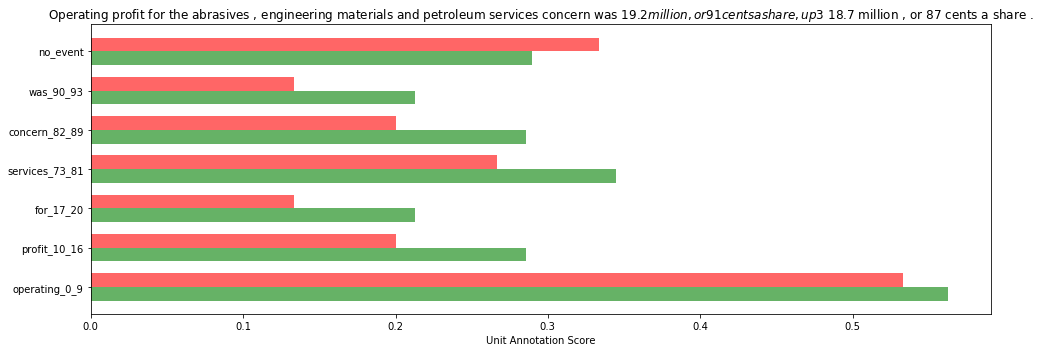

In [12]:
# Get the data out of the counter object
keys = lowQualitySentence['input.validate_verbs'].iloc[0].lower().split(" ")
keys.append('no_event')
y_pos = np.arange(len(keys))
# get the scores for each key
score_final = [lowQualitySentence['unit_annotation_score'].iloc[0][k] for k in keys]
score_initial = [lowQualitySentence['unit_annotation_score_initial'].iloc[0][k] for k in keys]

# create plot
bar_width = 0.35
opacity = 0.8

plt.barh(y_pos, score_final, bar_width, align='center', color="green", alpha=0.6)
plt.barh(y_pos + bar_width, score_initial, bar_width, align='center', color="red", alpha=0.6)
plt.yticks(y_pos + bar_width / 2, keys)
plt.xlabel('Unit Annotation Score')
plt.title(lowQualitySentence['input.sentence'].iloc[0])

plt.legend()
plt.tight_layout()
plt.show()
 


#### High Quality Sentence

In [13]:
highQualitySentence = sortUQS[(sortUQS['input.index'] == 166)]

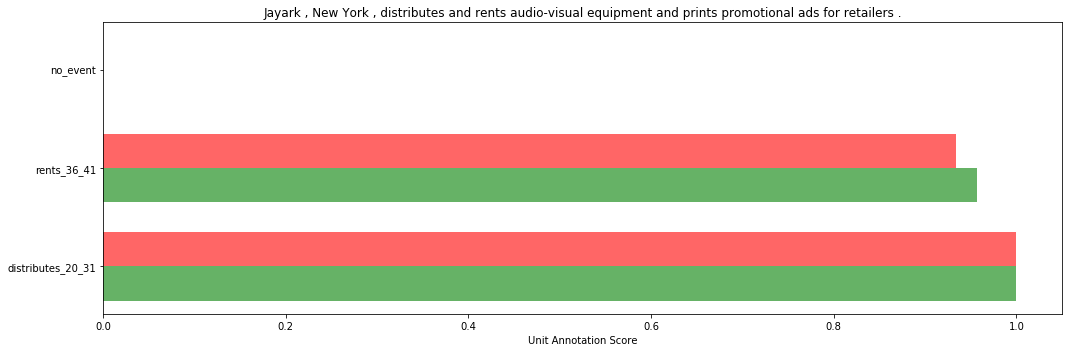

In [14]:
# Get the data out of the counter object
keys = highQualitySentence['input.validate_verbs'].iloc[-1].lower().split(" ")
keys.append('no_event')
y_pos = np.arange(len(keys))
# get the scores for each key
score_final = [highQualitySentence['unit_annotation_score'].iloc[-1][k] for k in keys]
score_initial = [highQualitySentence['unit_annotation_score_initial'].iloc[-1][k] for k in keys]

# create plot
bar_width = 0.35
opacity = 0.8

plt.barh(y_pos, score_final, bar_width, align='center', color="green", alpha=0.6)
plt.barh(y_pos + bar_width, score_initial, bar_width, align='center', color="red", alpha=0.6)
plt.yticks(y_pos + bar_width / 2, keys)
plt.xlabel('Unit Annotation Score')
plt.title(highQualitySentence['input.sentence'].iloc[-1])

plt.legend()
plt.tight_layout()
plt.show()

### Plot the worker quality score (UQS) at the beginning of the process and at the end


#### Print the results for the workers in our dataset

In [15]:
processed_results["workers"].head(10)

,worker-cosine,output.selectedtags_desc.count,job,duration,judgment,unit,worker-agreement,spam,wqs,wqs_initial
worker,,,,,,,,,,
1868958,0.203677,1.666667,1,14.000000,3,3,0.516667,False,0.483090,0.453048
1883056,0.144461,1.888889,1,21.444444,18,18,0.592077,False,0.675092,0.562287
1924522,0.222145,1.352941,1,10.588235,17,17,0.635162,False,0.598000,0.523248
3671372,0.221982,1.230769,1,13.461538,13,13,0.539245,False,0.589620,0.452123
4316379,0.412977,1.333333,1,13.958333,48,48,0.402640,False,0.307947,0.287236
5861591,0.236297,1.166667,1,21.000000,6,6,0.521000,False,0.543220,0.452736
6010674,0.320049,1.275862,1,55.896552,29,29,0.437716,False,0.403360,0.362782
6082058,0.185739,3.148148,1,25.166667,54,54,0.519088,False,0.567517,0.490242
6330997,0.350032,1.666667,1,63.333333,3,3,0.391219,False,0.299510,0.296047


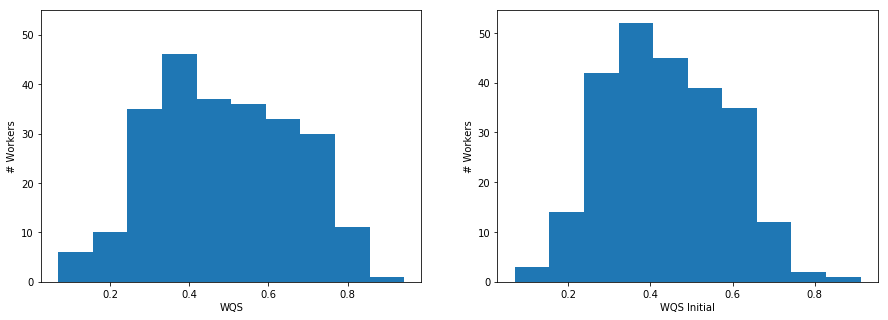

In [16]:
plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(processed_results["workers"]["wqs"])
plt.ylim(0, 55)
plt.xlabel("WQS")
plt.ylabel("# Workers")

plt.subplot(1, 2, 2)
plt.hist(processed_results["workers"]["wqs_initial"])
plt.xlabel("WQS Initial")
plt.ylabel("# Workers")

### Plot the change in worker qualtity score at the beginning of the process and at the end

In [17]:
sortWQS = processed_results["workers"].sort(['wqs'], ascending=[1])
sortWQS.head(10)

,worker-cosine,output.selectedtags_desc.count,job,duration,judgment,unit,worker-agreement,spam,wqs,wqs_initial
worker,,,,,,,,,,
43155126,0.702772,1.048780,1,18.243902,41,41,0.304624,False,0.069092,0.076438
43777974,0.670922,1.095238,1,14.047619,21,21,0.267998,False,0.069750,0.091610
37478331,0.716211,1.111111,1,16.888889,9,9,0.284355,False,0.074629,0.070515
26024737,0.533944,1.250000,1,8.000000,8,8,0.284146,False,0.129400,0.170087
43747423,0.537956,1.083333,1,18.250000,24,24,0.426383,False,0.152818,0.177890
43029456,0.460751,1.000000,1,24.500000,2,2,0.444444,False,0.155247,0.211848
42606210,0.483127,1.333333,1,23.500000,6,6,0.322515,False,0.163965,0.200462
6363996,0.536175,1.060606,1,43.590909,66,66,0.336481,False,0.165155,0.172865
42393430,0.558238,1.120000,1,17.800000,25,25,0.305036,False,0.166662,0.166373


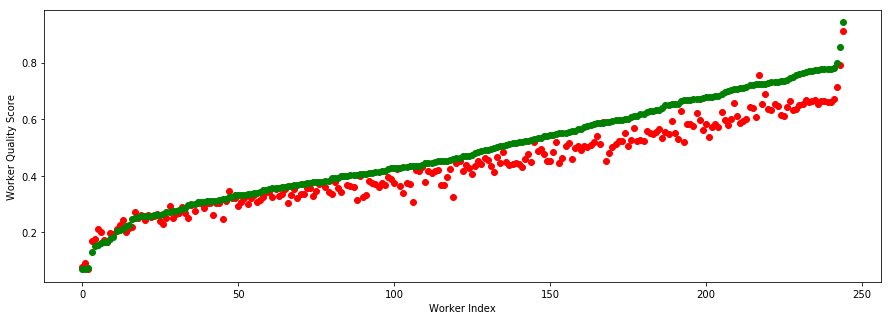

In [18]:
plt.rcParams['figure.figsize'] = 15, 5

plt.plot(np.arange(sortWQS.shape[0]), sortWQS["wqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortWQS.shape[0]), sortWQS["wqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Worker Quality Score')
plt.xlabel('Worker Index')
#plt.legend(loc=9, bbox_to_anchor=(0.5, 1.2), ncol=3, prop={'size':12})



# Analysis of the hands-on  session

In [21]:
import pandas as pd

event_validation_handson_filename = "/Users/oanainel/Downloads/f1190137.csv"
event_validation_handson_dataset = pd.read_csv(event_validation_handson_filename)

event_validation_handson_dataset.head(10)

,_unit_id,_created_at,_id,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,_city,_ip,hiddeninput,selectedtags_desc,doc_id,hiddeninput_gold,index,selectedtags_desc_gold,sentence,sentence_id,uqs,uqs_initial,validate_verbs
0,1373127405,9/11/2017 11:54:38,2821519241,9/11/2017 11:51:25,False,cf_internal,1.0,43859718,NLD,07,Amsterdam,95.97.10.30,NaN,"[""chooses_8_15"",""war_25_28"",""open_193_197"",""dr...",WSJ900813-0157,NaN,626,NaN,If Iraq chooses a simple war of nerves and eco...,40,0.704231,0.637294,chooses_8_15 war_25_28 knows_88_93 try_117_120...
1,1373127405,9/11/2017 11:55:08,2821520278,9/11/2017 11:53:08,False,cf_internal,1.0,43870895,NLD,07,Amsterdam,95.97.10.30,NaN,"[""chooses_8_15"",""war_25_28"",""knows_88_93"",""try...",WSJ900813-0157,NaN,626,NaN,If Iraq chooses a simple war of nerves and eco...,40,0.704231,0.637294,chooses_8_15 war_25_28 knows_88_93 try_117_120...
2,1373127405,9/11/2017 11:55:48,2821521712,9/11/2017 11:53:16,False,cf_internal,1.0,43870896,USA,NY,New York,24.38.10.6,NaN,"[""war_25_28"",""effort_290_296"",""deal_326_330""]",WSJ900813-0157,NaN,626,NaN,If Iraq chooses a simple war of nerves and eco...,40,0.704231,0.637294,chooses_8_15 war_25_28 knows_88_93 try_117_120...
3,1373127405,9/11/2017 11:55:54,2821521922,9/11/2017 11:54:13,False,cf_internal,1.0,43870897,NLD,NaN,NaN,89.200.38.28,NaN,"[""no_event""]",WSJ900813-0157,NaN,626,NaN,If Iraq chooses a simple war of nerves and eco...,40,0.704231,0.637294,chooses_8_15 war_25_28 knows_88_93 try_117_120...
4,1373127405,9/11/2017 11:56:02,2821522224,9/11/2017 11:52:18,False,cf_internal,1.0,43870887,BGR,NaN,NaN,149.62.200.218,NaN,"[""chooses_8_15"",""war_25_28"",""open_193_197"",""dr...",WSJ900813-0157,NaN,626,NaN,If Iraq chooses a simple war of nerves and eco...,40,0.704231,0.637294,chooses_8_15 war_25_28 knows_88_93 try_117_120...
5,1373127405,9/11/2017 11:56:33,2821523220,9/11/2017 11:53:13,False,cf_internal,1.0,43870893,NLD,07,Amsterdam,95.97.10.30,NaN,"[""chooses_8_15"",""try_117_120"",""open_193_197"",""...",WSJ900813-0157,NaN,626,NaN,If Iraq chooses a simple war of nerves and eco...,40,0.704231,0.637294,chooses_8_15 war_25_28 knows_88_93 try_117_120...
6,1373127405,9/11/2017 11:56:39,2821523423,9/11/2017 11:52:41,False,cf_internal,1.0,43870891,NLD,11,Alphen Aan Den Rijn,37.0.94.161,NaN,"[""chooses_8_15"",""war_25_28"",""open_193_197""]",WSJ900813-0157,NaN,626,NaN,If Iraq chooses a simple war of nerves and eco...,40,0.704231,0.637294,chooses_8_15 war_25_28 knows_88_93 try_117_120...
7,1373127405,9/11/2017 11:58:01,2821526235,9/11/2017 11:51:46,False,cf_internal,1.0,25745953,NLD,07,Amsterdam,95.97.10.30,NaN,"[""chooses_8_15"",""war_25_28"",""accept_314_320"",""...",WSJ900813-0157,NaN,626,NaN,If Iraq chooses a simple war of nerves and eco...,40,0.704231,0.637294,chooses_8_15 war_25_28 knows_88_93 try_117_120...
8,1373127405,9/11/2017 11:59:55,2821530199,9/11/2017 11:55:32,False,cf_internal,1.0,43870888,NLD,07,Amsterdam,95.97.10.30,NaN,"[""chooses_8_15"",""knows_88_93""]",WSJ900813-0157,NaN,626,NaN,If Iraq chooses a simple war of nerves and eco...,40,0.704231,0.637294,chooses_8_15 war_25_28 knows_88_93 try_117_120...
9,1373127406,9/11/2017 11:55:09,2821520302,9/11/2017 11:54:41,False,cf_internal,1.0,43859718,NLD,07,Amsterdam,95.97.10.30,NaN,"[""publishes_10_19"",""operates_96_104""]",wsj_0152,NaN,244,NaN,"Dow Jones publishes The Wall Street Journal , ...",7,1.000000,1.000000,publishes_10_19 operates_96_104


In [22]:
import sys
sys.path.append('../')

from defaultconfig import Configuration

class EventValidationHandsonConfig(Configuration):
    inputColumns = ["doc_id", "index", "sentence_id", "sentence", "validate_verbs"]
    outputColumns = ["selectedtags_desc"]
    
    # processing of a closed task
    open_ended_task = True
    annotation_vector = [
        "causes", "manifestation", "treats", "prevents", "symptom", "diagnose_by_test_or_drug", "location",
        "side_effect", "contraindicates", "associated_with", "is_a", "part_of", "other", "none"
    ]
    
    def processJudgments(self, judgments):
        # change default separator to whitespace to make it work with our file
        for col in self.outputColumns:
            judgments[col] = judgments[col].apply(lambda x: x.replace(' ',','))
        return judgments

config_handson = EventValidationHandsonConfig()

In [23]:
from controllers.inputController import processFile
pre_processed_results_handson = processFile(
    root=".", directory="", filename=event_validation_handson_filename,
    config=config_handson
)

In [24]:
# run the metrics
from models import Metrics
handson_processed_results = Metrics.run(pre_processed_results_handson, config_handson)

### Plot the unit quality score (UQS) at the beginning of the process and at the end

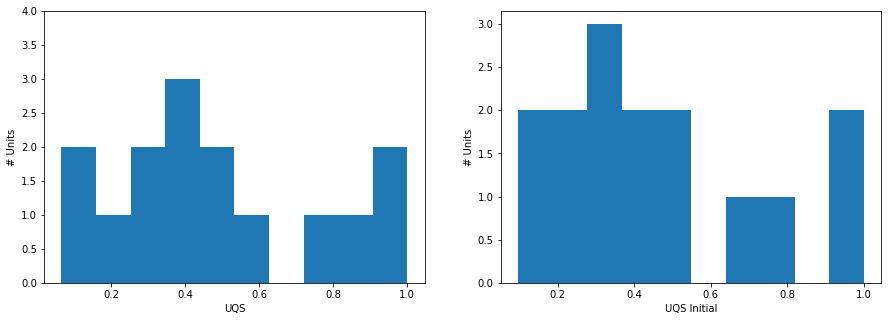

In [26]:

plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(handson_processed_results["units"]["uqs"])
plt.ylim(0, 4)
plt.xlabel("UQS")
plt.ylabel("# Units")

plt.subplot(1, 2, 2)
plt.hist(handson_processed_results["units"]["uqs_initial"])
plt.xlabel("UQS Initial")
plt.ylabel("# Units")

### Compare the units quality: handson results vs. large crowd

In [27]:
# create the subset of the large crowd
subset_crowd = processed_results["units"][processed_results["units"]["input.index"].isin(set(handson_processed_results["units"]["input.index"]))]
subset_crowd = subset_crowd.sort(['uqs'], ascending=[1])

In [28]:
subset = pd.DataFrame(subset_crowd["input.index"])
handson_results = pd.merge(subset, handson_processed_results["units"], left_on=["input.index"], right_on=["input.index"], how="left")
handson_results

,input.index,duration,input.doc_id,input.sentence,input.sentence_id,input.validate_verbs,job,metrics.avg_annotations,metrics.avg_cos_clarity,metrics.avg_unique_annotations,output.selectedtags_desc,output.selectedtags_desc.annotations,output.selectedtags_desc.cos_clarity,output.selectedtags_desc.unique_annotations,worker,uqs,uqs_initial,unit_annotation_score,unit_annotation_score_initial
0,496,52.444444,wsj_0768,Mutual funds are the among the largest holders...,15,are_13_16 among_21_26 accounting_57_67 for_68_...,/Users/oanainel/Downloads/f1190137,14.0,0.903696,6.0,"{u'among_21_26': 1, u'accounting_57_67': 7, u'...",14,0.903696,6,9,0.566646,0.483446,"{u'among_21_26': 0.100777378243, u'are_13_16':...","{u'among_21_26': 0.111111111111, u'are_13_16':..."
1,196,27.500000,wsj_0159,"Cara , a food services chain operator and Unic...",8,holding_54_61 are_72_75 based_76_81,/Users/oanainel/Downloads/f1190137,5.0,0.904534,3.0,"{u'no_event': 3, u'are_72_75': 1, u'based_76_8...",5,0.904534,3,4,0.468546,0.500000,"{u'no_event': 0.735362699792, u'are_72_75': 0....","{u'no_event': 0.75, u'are_72_75': 0.25, u'base..."
2,482,26.250000,wsj_0610,The new facility was to have been the world 's...,30,was_17_20 have_24_28 been_29_33 manufacturing_...,/Users/oanainel/Downloads/f1190137,5.0,0.755929,4.0,"{u'no_event': 2, u'construction_113_125': 1, u...",5,0.755929,4,4,0.109952,0.166667,"{u'no_event': 0.431183640512, u'manufacturing_...","{u'no_event': 0.5, u'manufacturing_68_81': 0.2..."
3,220,27.600000,wsj_0610,"Kellogg is based in Battle Creek , Mich. , a c...",14,is_8_10 based_11_16 calls_55_60,/Users/oanainel/Downloads/f1190137,6.0,0.577350,3.0,"{u'no_event': 2, u'calls_55_60': 2, u'based_11...",6,0.577350,3,5,0.256277,0.241421,"{u'no_event': 0.315333820876, u'calls_55_60': ...","{u'no_event': 0.4, u'calls_55_60': 0.4, u'base..."
4,370,46.444444,wsj_0610,Each share point is worth about $ 60 million i...,9,is_17_19 worth_20_25 in_45_47 sales_48_53,/Users/oanainel/Downloads/f1190137,14.0,0.589768,5.0,"{u'no_event': 4, u'is_17_19': 2, u'sales_48_53...",14,0.589768,5,9,0.280858,0.300790,"{u'no_event': 0.406516351101, u'is_17_19': 0.2...","{u'no_event': 0.444444444444, u'is_17_19': 0.2..."
5,612,52.800000,WSJ900813-0157,There are disagreements among experts about ho...,46,are_6_9 among_24_29 pressure_53_61 be_67_69 ne...,/Users/oanainel/Downloads/f1190137,17.0,0.507093,10.0,"{u'no_event': 1, u'pressure_161_169': 2, u'mak...",17,0.507093,10,5,0.251546,0.188389,"{u'no_event': 0.0995161345984, u'pressure_161_...","{u'no_event': 0.2, u'pressure_161_169': 0.4, u..."
6,471,28.750000,ABC19980304.1830.1636,"It is , in short , the kind of management job ...",11,is_3_5 in_8_10 say_66_69 had_79_82 fight_86_91...,/Users/oanainel/Downloads/f1190137,7.0,0.666667,6.0,"{u'no_event': 1, u'for_92_95': 1, u'fight_86_9...",7,0.666667,6,4,0.065422,0.096225,"{u'no_event': 0.295106485557, u'for_92_95': 0....","{u'no_event': 0.25, u'for_92_95': 0.25, u'figh..."
7,577,62.222222,NYT19980206.0460,The less money the government needs to borrow ...,22,needs_30_35 borrow_39_45 is_57_59 freed_60_65 ...,/Users/oanainel/Downloads/f1190137,19.0,0.601929,7.0,"{u'no_event': 3, u'is_57_59': 1, u'borrow_39_4...",19,0.601929,7,9,0.375916,0.337196,"{u'no_event': 0.260141998564, u'is_57_59': 0.1...","{u'no_event': 0.333333333333, u'is_57_59': 0.1..."
8,226,50.444444,wsj_0781,"That 's a break from Compaq tradition , becaus...",32,s_5_7 does_60_64 announce_69_77 're_98_101,/Users/oanainel/Downloads/f1190137,10.0,0.833333,4.0,"{u'no_event': 1, u'announce_69_77': 5, u's_5_7...",10,0.833333,4,9,0.369502,0.328567,"{u'no_event': 0.102409776794, u'announce_69_77...","{u'no_event': 0.111111111111, u'announce_69_77..."
9,626,207.333333,WSJ900813-0157,If Iraq chooses a simple war of nerves and eco...,40,chooses_8_15 war_25_28 knows_88_93 try_117_120...,/Users/oanainel/Downloads/f1190137,38.0,0.530669,11.0,"{u'open_193_197': 5, u'no_event': 1, u'drop_27...",38,0.530669,11,9,0.436762,0.398495,"{u'open_193_19

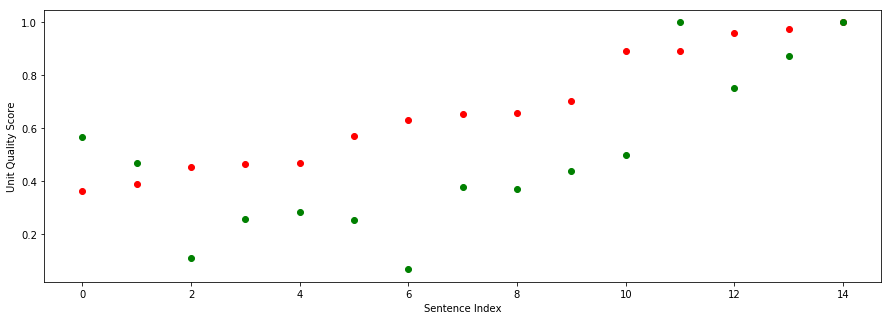

In [29]:
plt.rcParams['figure.figsize'] = 15, 5

#sortUQS = processed_results["units"].sort(['uqs'], ascending=[1])
plt.plot(np.arange(subset_crowd.shape[0]), subset_crowd["uqs"], 'ro', lw = 1, label = "Large Crowd UQS")
plt.plot(np.arange(handson_results.shape[0]), handson_results["uqs"], 'go', lw = 1, label = "Handson Crowd UQS")

plt.ylabel('Unit Quality Score')
plt.xlabel('Sentence Index')



## Pair-wise comparison of results on individual units

In [31]:
handson_results["input.index"]

0     496
1     196
2     482
3     220
4     370
5     612
6     471
7     577
8     226
9     626
10    456
11    596
12    127
13    166
14    244
Name: input.index, dtype: int64

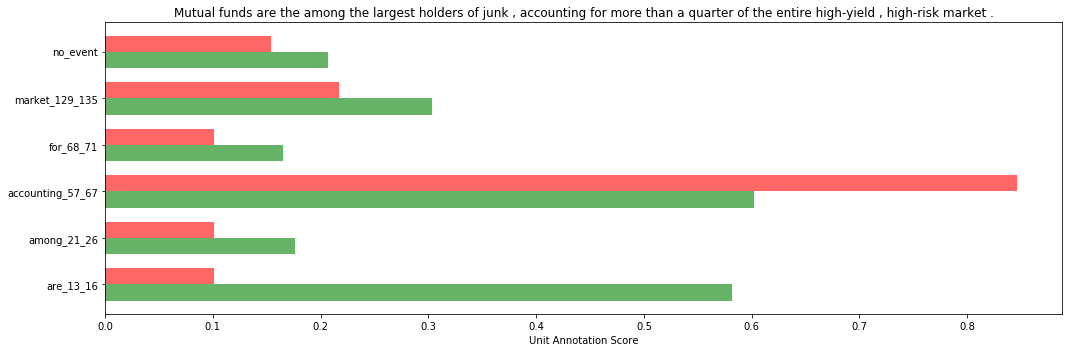

In [32]:
largeCrowd = subset_crowd[(subset_crowd['input.index'] == 496)]
handsonCrowd = handson_results[(handson_results["input.index"] == 496)]

# Get the data out of the counter object
keys = largeCrowd['input.validate_verbs'].iloc[0].lower().split(" ")
keys.append('no_event')

y_pos = np.arange(len(keys))
# get the scores for each key
score_large_crowd = [largeCrowd['unit_annotation_score'].iloc[0][k] for k in keys]
score_handson_crowd = [handsonCrowd['unit_annotation_score'].iloc[0][k] for k in keys]

# create plot
bar_width = 0.35
opacity = 0.8

plt.barh(y_pos, score_large_crowd, bar_width, align='center', color="green", alpha=0.6)
plt.barh(y_pos + bar_width, score_handson_crowd, bar_width, align='center', color="red", alpha=0.6)
plt.yticks(y_pos + bar_width / 2, keys)
plt.xlabel('Unit Annotation Score')
plt.title(largeCrowd['input.sentence'].iloc[0])

plt.legend()
plt.tight_layout()
plt.show()